In [4]:
import sys, os
sys.path.append('../deep-learning-from-scratch')  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist

# 最初の呼び出しは時間がかかる
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False
# データ形式の出力
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


## 3.6 手書き数字認識
学習済みのモデルを用いた推論処理を実装する

### 3.6.1 MNISTデータセット
0から9までの数字画像からなるデータセット
- 訓練画像60000枚、テスト画像10000枚
- 28px x 28px
- 各ピクセルの値(明度)は0-255のグレースケール

- 各画像は、28x28=784行のベクトルで表されている
- x_train, t_trainは訓練データの画像・正解データ
- x_test, t_testは訓練データの画像・正解データ

t_train,t_testは、0から10までの値を取る(画像が表す数字の正解)が、以下のようにone_hot表現で取得することも可能である

one_hot表現とは、`[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`のように正解となるラベルが1(この場合は5が正解)で、それ以外が0の配列

In [6]:
import sys, os
import numpy as np
sys.path.append('../deep-learning-from-scratch')  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False, one_hot_label=True)

# データ形式の出力
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

# 試しに1つ表示
print(t_train[0])

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


5
(784,)
(28, 28)


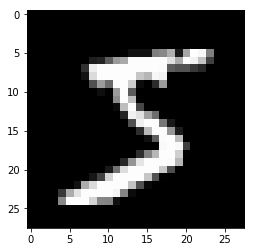

In [10]:
import sys, os
sys.path.append('../deep-learning-from-scratch')  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
import numpy as np
from dataset.mnist import load_mnist
from PIL import Image


def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    # jupyter labで表示するために、少し変えている。グレースケールで表示。
    plt.imshow(pil_img,cmap='gray')

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

img = x_train[0]
label = t_train[0]
print(label)  # 5

print(img.shape)  # (784,)
img = img.reshape(28, 28)  # 形状を元の画像サイズに変形
print(img.shape)  # (28, 28)

img_show(img)

### 3.6.2 ニューラルネットワークの推論処理
- 入力層は784(28*28), 出力層が10個のニューラルネットワークを実装する

In [49]:
import sys, os
import numpy as np
import pickle
sys.path.append('../deep-learning-from-scratch')  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(a_big):
    c = np.max(a_big)
    a = a_big - c
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False, one_hot_label=False)
    return x_test,t_test

# pickleという機能を用いることにより、実行中のオブジェクトをファイルとして保存することが出来る
# pickleファイルをロードすることにより、実行中のオブジェクトを即座に復元できる
def init_network():
    with open("../deep-learning-from-scratch/ch03/sample_weight.pkl",'rb') as f:
        network = pickle.load(f)
    return network

def predict(network,x):
    #　各層の重み
    W1,W2,W3 = network['W1'], network['W2'],network['W3']
    #　各層のバイアス
    b1,b2,b3 = network['b1'], network['b2'],network['b3']
    
    # 第一層の推論
    a1 = np.dot(x,W1) + b1
    z1 = sigmoid(a1)
    
    # 第二層の推論
    a2 = np.dot(z1,W2) + b2
    z2 = sigmoid(a2)
    
    # 出力層の推論
    a3 = np.dot(z2,W3) + b3
    # 分類なのでsoftmaxを用いている
    y = softmax(a3)
    return y

In [54]:
x, t = get_data()
network = init_network()

# 正解数
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network,x[i])
    p = np.argmax(y) #最も確率が高い要素のインデックスを取得
    if p == t[i]:
        accuracy_cnt += 1
print("Accuracy: "+ str(float(accuracy_cnt)/len(x)))

Accuracy: 0.9207


分類の正解率は92.07%となった

- `normalize=True` としているのは、0-255であった各ピクセルの値を255で除算して、0.0-1.0の範囲に収まるようにしている
- このような、ある範囲にデータが収まるようにする処理を、**正規化**という。
- 一般的に、入力データに対して何かしらの決まった変換を行うことを**前処理**と言う

### 3.6.3 バッチ処理
推論を複数の入力に対してまとめて行いたい場合を考える。

入力と重みにの形状(行列の次元)に注目してみる

In [51]:
x, _ = get_data()
network = init_network()
W1,W2,W3 = network['W1'], network['W2'],network['W3']

print(x.shape)
# (10000, 784)
print(x[0:1].shape)
# xのうち1列を取り出す
# (0, 784)
print(W1.shape)
# (784, 50)
print(W2.shape)
# (50, 100)
print(W3.shape)
# (100, 10)

(10000, 784)
(1, 784)
(784, 50)
(50, 100)
(100, 10)


1つの画像を入力とした推論の形状は、以下のようになる
- $X: 1\times784$
- $W_1: 784\times 50$
- $W_2: 50\times 100$
- $W_3: 100\times 10$
- $Y: 1 \times 10$

順番に掛け算を行うと、

$X: 1\times784$

-> $XW_1: 1\times 50$

-> $XW_1W_2: 1\times 100$

-> $Y=XW_1W_2W_3: 1\times 10$

ただし、100枚分の画像を列として並べてXの形状を$100 \times 784$とすると、100枚分のデータをまとめて処理することができる。

順番に掛け算を行うと、

$X: 100\times784$

-> $XW_1: 100\times 50$

-> $XW_1W_2: 100\times 100$

-> $Y=XW_1W_2W_3: 100\times 10$

これを実装する。

In [55]:
x, _ = get_data()
network = init_network()

batch_size = 100
accuracy_cnt = 0

for i in range(0,len(x),batch_size): # i が batch_size=100ずつ増える。len(x)=10000を超えないまで
    x_batch = x[i:i+batch_size]    # 100件分の入力 (100,784)
    y_batch = predict(network,x_batch)    # 100件分の推論結果 (100,1)

    p = np.argmax(y_batch, axis = 1)     # 1次元目を軸として(列ごとに)最大値を計算する。要素100個の配列になる
    accuracy_cnt += np.sum(p == t[i:i+batch_size])     # True, Falseからなる配列(pと一致する時にTrue)を作成し、和を取ることで正解数がわかる

print("Accuracy: "+ str(float(accuracy_cnt)/len(x)))

Accuracy: 0.9207


結果は同じだが、for文を回す回数が少なくなるため推論が早くなる。